Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [1]:
from sklearn.datasets import load_digits
digits = load_digits()

In [2]:
print(f'{digits.data.shape} - digits.data; {digits.images.shape} - digits.images')

(1797, 64) - digits.data; (1797, 8, 8) - digits.images


In [3]:
X, y = digits.data, digits.target
# X, y = load_digits(return_X_y=True) #alternative upload

**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

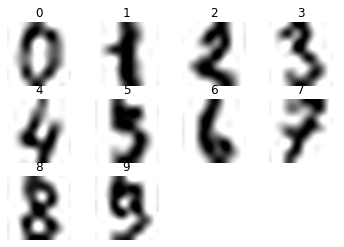

In [5]:
# with lanczos interpolation
plt.gray()
_, axes = plt.subplots(nrows=3, ncols=4)
i = 0
for ax, image, label in zip(axes.flatten(), X, y):
    if  i <= 9:
        ax.set_axis_off()
        ax.imshow(image.reshape(8, 8), cmap='binary',  interpolation='lanczos')
        ax.set_title(label)
    else:
        ax.set_axis_off()
    i += 1
plt.show() 

<Figure size 432x288 with 0 Axes>

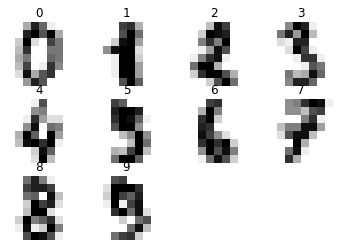

In [6]:
# withount interpolation
plt.gray()
_, axes = plt.subplots(nrows=3, ncols=4)
i = 0
for ax, image, label in zip(axes.flatten(), X, y):
    if  i <= 9:
        ax.set_axis_off()
        ax.imshow(image.reshape(8, 8), cmap='binary',  interpolation=None)
        ax.set_title(label)
    else:
        ax.set_axis_off()
    i += 1
plt.show() 

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [7]:
from sklearn.cluster import AgglomerativeClustering, KMeans

In [8]:
# AgglomerativeClustering
Model_AgClust = AgglomerativeClustering(n_clusters=10)
Y_fcst_AgClust = Model_AgClust.fit_predict(X)

In [9]:
Y_fcst_AgClust

array([7, 9, 4, ..., 4, 1, 4], dtype=int64)

In [10]:
digits.target

array([0, 1, 2, ..., 8, 9, 8])

In [11]:
# KMeans
Model_KMeans = KMeans(n_clusters=10, n_init=1000, random_state=42)
Y_fcst_KMeans = Model_KMeans.fit_predict(X)

**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.


<Figure size 432x288 with 0 Axes>

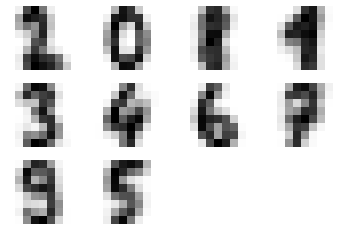

In [12]:
#KMeans
clusters_KMeans = np.empty((10, 64))
for i in range(0,10):
    clusters_KMeans[i] = X[Y_fcst_KMeans == i].mean(axis=0)
# withount interpolation
plt.gray()
_, axes = plt.subplots(nrows=3, ncols=4)
for ax, image in zip(axes.flatten(), clusters_KMeans):
    ax.set_axis_off()
    ax.imshow(image.reshape(8, 8), cmap='binary',  interpolation=None)
    axes.flatten()[10].set_axis_off()
    axes.flatten()[11].set_axis_off()
plt.show() 

<Figure size 432x288 with 0 Axes>

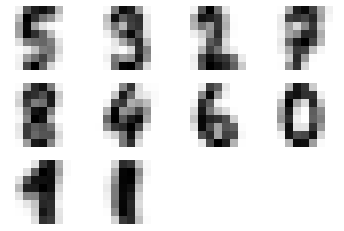

In [13]:
# AgglomerativeClustering
clusters_AgClust = np.empty((10, 64))
for i in range(0,10):
    clusters_AgClust[i] = X[Y_fcst_AgClust == i].mean(axis=0)
    # withount interpolation
plt.gray()
_, axes = plt.subplots(nrows=3, ncols=4)
for ax, image in zip(axes.flatten(), clusters_AgClust):
    ax.set_axis_off()
    ax.imshow(image.reshape(8, 8), cmap='binary',  interpolation=None)
    axes.flatten()[10].set_axis_off()
    axes.flatten()[11].set_axis_off()
plt.show() 

In [14]:
# Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?
# KMeans даёт центры кластеров, больше похожие на типичные начертания цифр.

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [15]:
from sklearn.metrics import silhouette_score

In [16]:
silhouette_KMeans = []
for K in range(2,21):
    model_y = KMeans(n_clusters=K, n_init=1000, random_state=42).fit_predict(X)
    silhouette_KMeans.append(silhouette_score(X, model_y))

In [17]:
silhouette_AgClust = []
for K in range(2,21):
    model_y = AgglomerativeClustering(n_clusters=K).fit_predict(X)
    silhouette_AgClust.append(silhouette_score(X, model_y))

In [18]:
x_label = [x for x in range(2,21)]

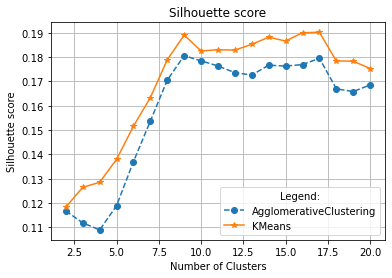

In [19]:
plt.plot(x_label, silhouette_AgClust, label='AgglomerativeClustering', linestyle='--', marker='o')
plt.plot(x_label, silhouette_KMeans, label='KMeans', linestyle='-', marker='*')
plt.legend(title='Legend:')
plt.title('Silhouette score')
plt.xlabel("Number of Clusters")
plt.ylabel('Silhouette score')
plt.grid()
plt.show()

In [20]:
max_s_KMeans_cluster = x_label[np.array(silhouette_KMeans).argmax()]
max_s_AgClust_cluster = x_label[np.array(silhouette_AgClust).argmax()]

In [21]:
print('При каком числе кластеров достигается максимум силуэта?')
print(f'Максимум силуэта для иерархической кластеризации достигается при {max_s_AgClust_cluster} кластерах - {round(np.array(silhouette_AgClust).max(),3)}')
print(f'Максимум силуэта для метода 𝐾 средних достигается при {max_s_KMeans_cluster} кластерах - {round(np.array(silhouette_KMeans).max(),3)}')

При каком числе кластеров достигается максимум силуэта?
Максимум силуэта для иерархической кластеризации достигается при 9 кластерах - 0.181
Максимум силуэта для метода 𝐾 средних достигается при 17 кластерах - 0.19


Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [22]:
from sklearn.metrics import v_measure_score

In [23]:
v_measure_score_KMeans = []
for K in range(2,21):
    model_y = KMeans(n_clusters=K, n_init=1000, random_state=42).fit_predict(X)
    v_measure_score_KMeans.append(v_measure_score(y, model_y))

In [24]:
v_measure_score_AgClust = []
for K in range(2,21):
    model_y = AgglomerativeClustering(n_clusters=K).fit_predict(X)
    v_measure_score_AgClust.append(v_measure_score(y, model_y))

In [25]:
x_label = [x for x in range(2,21)]

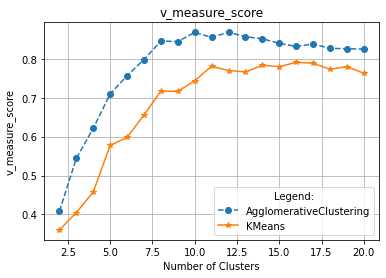

In [26]:
plt.plot(x_label, v_measure_score_AgClust, label='AgglomerativeClustering', linestyle='--', marker='o')
plt.plot(x_label, v_measure_score_KMeans, label='KMeans', linestyle='-', marker='*')
plt.legend(title='Legend:')
plt.title('v_measure_score')
plt.xlabel("Number of Clusters")
plt.ylabel('v_measure_score')
plt.grid()
plt.show()

In [27]:
max_vm_KMeans_cluster = x_label[np.array(v_measure_score_KMeans).argmax()]
max_vm_AgClust_cluster = x_label[np.array(v_measure_score_AgClust).argmax()]

In [28]:
print('При каком числе кластеров достигается максимум 𝑉 -меры?')
print(f'Максимум 𝑉-меры для иерархической кластеризации достигается при {max_vm_AgClust_cluster} кластерах - {round(np.array(v_measure_score_AgClust).max(),3)}')
print(f'Максимум 𝑉-меры для метода 𝐾 средних достигается при {max_vm_KMeans_cluster} кластерах - {round(np.array(v_measure_score_KMeans).max(),3)}')

При каком числе кластеров достигается максимум 𝑉 -меры?
Максимум 𝑉-меры для иерархической кластеризации достигается при 12 кластерах - 0.869
Максимум 𝑉-меры для метода 𝐾 средних достигается при 16 кластерах - 0.791


# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [29]:
from sklearn.decomposition import TruncatedSVD

# исходные данные
model_KMeans = KMeans(n_clusters=10, n_init=1000, random_state=42).fit_predict(X)
vm_KMeans = v_measure_score(y, model_KMeans)
s_KMeans = silhouette_score(X, model_KMeans)
    
model_AgClust = AgglomerativeClustering(n_clusters=10).fit_predict(X)
vm_AgClust = v_measure_score(y, model_AgClust)
s_AgClust = silhouette_score(X, model_AgClust)

print('Исходные данные')
print(f'K-means кластеризация: силуэт - {s_KMeans}, V-мера - {vm_KMeans}.')
print(f'Иерархическая: силуэт - {s_AgClust}, V-мера - {vm_AgClust}.')
print('')
print('Сингулярное разложение матрицы X')

# с сингулярным разложением матрицы
feat_qty = [2,5,10,20]

for i in feat_qty:
    
    Xt = TruncatedSVD(n_components=i, random_state=42).fit_transform(X)
    
    model_KMeans = KMeans(n_clusters=10, n_init=1000, random_state=42).fit_predict(Xt)
    vm_KMeans = v_measure_score(y, model_KMeans)
    s_KMeans = silhouette_score(X, model_KMeans)
    
    model_AgClust = AgglomerativeClustering(n_clusters=10).fit_predict(Xt)
    vm_AgClust = v_measure_score(y, model_AgClust)
    s_AgClust = silhouette_score(X, model_AgClust)
    
    print(f'Количество признаков: {i}.')
    print(f'K-means кластеризация: силуэт - {s_KMeans}, V-мера - {vm_KMeans}.')
    print(f'Иерархическая: силуэт - {s_AgClust}, V-мера - {vm_AgClust}.')
    print('')

Исходные данные
K-means кластеризация: силуэт - 0.18255472509950926, V-мера - 0.7437190191202068.
Иерархическая: силуэт - 0.17849659940596496, V-мера - 0.8681701126909083.

Сингулярное разложение матрицы X
Количество признаков: 2.
K-means кластеризация: силуэт - 0.006439834290468351, V-мера - 0.34687799059639063.
Иерархическая: силуэт - -0.007681018630218928, V-мера - 0.3337189903948925.

Количество признаков: 5.
K-means кластеризация: силуэт - 0.1684930474709176, V-мера - 0.6339843180848355.
Иерархическая: силуэт - 0.1620113963829507, V-мера - 0.6756036446423491.

Количество признаков: 10.
K-means кластеризация: силуэт - 0.18050894235987397, V-мера - 0.722042831950702.
Иерархическая: силуэт - 0.1765881132796084, V-мера - 0.8259753348813222.

Количество признаков: 20.
K-means кластеризация: силуэт - 0.18239687328406531, V-мера - 0.741491147536787.
Иерархическая: силуэт - 0.16913283397404957, V-мера - 0.8143882689038883.



In [30]:
# Удалось ли при каком-нибудь  𝑑′  получить силуэт и / или  𝑉 -меру лучше, чем на исходных данных?
## Максимумы показателей силуэта и v-меры при 10 кластерах при сингулярном разложеним матрицы X, 
## оставляя 2, 5, 10, 20 признаков не были лучше.

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

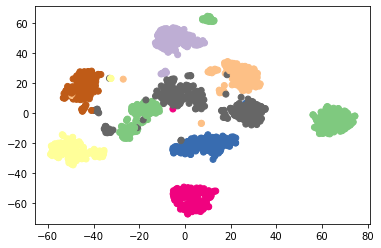

In [31]:
from sklearn.manifold import TSNE
# t-distributed Stochastic Neighbor Embedding
X_TSNE = TSNE(n_components=2, random_state=42).fit_transform(X)
#visualization
plt.scatter(x=X_TSNE[:,0], y=X_TSNE[:,1], c=y, cmap='Accent')
plt.show()

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [32]:
#  tSNE-преобразованные данные с 2 признаками
model_KMeans = KMeans(n_clusters=10, n_init=1000, random_state=42).fit_predict(X_TSNE)
vm_KMeans = v_measure_score(y, model_KMeans)
s_KMeans = silhouette_score(X, model_KMeans)
    
model_AgClust = AgglomerativeClustering(n_clusters=10).fit_predict(X_TSNE)
vm_AgClust = v_measure_score(y, model_AgClust)
s_AgClust = silhouette_score(X, model_AgClust)

print(f'K-means кластеризация: силуэт - {s_KMeans}, V-мера - {vm_KMeans}.')
print(f'Иерархическая: силуэт - {s_AgClust}, V-мера - {vm_AgClust}.')
print('')

print('Исходные данные')
print('K-means кластеризация: силуэт - 0.18255472509950926, V-мера - 0.7437190191202068.')
print('Иерархическая: силуэт - 0.17849659940596496, V-мера - 0.8681701126909083.')

K-means кластеризация: силуэт - 0.16347034069873623, V-мера - 0.9137798316714034.
Иерархическая: силуэт - 0.1641788047760139, V-мера - 0.9111471953871231.

Исходные данные
K-means кластеризация: силуэт - 0.18255472509950926, V-мера - 0.7437190191202068.
Иерархическая: силуэт - 0.17849659940596496, V-мера - 0.8681701126909083.


In [33]:
# Удалось ли получить силуэт и / или  𝑉 -меру лучше, чем на исходных данных?

## Для tSNE-преобразованных данных с 2 признаками удалось получить 𝑉 -меру лучше, 
## чем на исходных данных для обоих кластеризаций. Показатель силуэта стал ниже после tSNE преобразования данных.

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

In [34]:
# Визуализация для разбиения tSNE-преобразованных данных 𝐾-means кластеризацией

# повторяю модель, провожу расчет центроидов 
Y_fcst_KMeans = KMeans(n_clusters=10, n_init=1000, random_state=42).fit_predict(X_TSNE)
clusters_KMeans = np.empty((10, 64))
for i in range(0,10):
    clusters_KMeans[i] = X[Y_fcst_KMeans == i].mean(axis=0)

<Figure size 432x288 with 0 Axes>

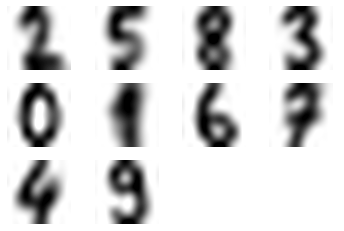

In [35]:
# и код для графика, с интерполяцией
plt.gray()
_, axes = plt.subplots(nrows=3, ncols=4)
for ax, image in zip(axes.flatten(), clusters_KMeans):
    ax.set_axis_off()
    ax.imshow(image.reshape(8, 8), cmap='binary',  interpolation='lanczos')
    axes.flatten()[10].set_axis_off()
    axes.flatten()[11].set_axis_off()
plt.show() 

In [36]:
import pandas as pd
digits_clusters = pd.DataFrame([y, Y_fcst_KMeans]).transpose()
digits_clusters.columns = ['Actual','Fcst_Code']

In [37]:
# change cluster codes to real numbers
digits_clusters.loc[digits_clusters['Fcst_Code'] == 0, 'Fcst'] = 3
digits_clusters.loc[digits_clusters['Fcst_Code'] == 1, 'Fcst'] = 7
digits_clusters.loc[digits_clusters['Fcst_Code'] == 2, 'Fcst'] = 6
digits_clusters.loc[digits_clusters['Fcst_Code'] == 3, 'Fcst'] = 2
digits_clusters.loc[digits_clusters['Fcst_Code'] == 4, 'Fcst'] = 1
digits_clusters.loc[digits_clusters['Fcst_Code'] == 5, 'Fcst'] = 8
digits_clusters.loc[digits_clusters['Fcst_Code'] == 6, 'Fcst'] = 0
digits_clusters.loc[digits_clusters['Fcst_Code'] == 7, 'Fcst'] = 5
digits_clusters.loc[digits_clusters['Fcst_Code'] == 8, 'Fcst'] = 4
digits_clusters.loc[digits_clusters['Fcst_Code'] == 9, 'Fcst'] = 9

# add Actual == Fcst column
for i in range(1797):
    if digits_clusters.loc[i, 'Actual'] == int(digits_clusters.loc[i, 'Fcst']):
        digits_clusters.loc[i, 'Correct'] = 1
    else:
        digits_clusters.loc[i, 'Correct'] = 0        

In [38]:
guess_share = []
for k in range(10):
    share = digits_clusters[digits_clusters['Actual'] == k]['Correct'].mean()
    guess_share.append(round(share * 100, 2))
guess_share = pd.Series(guess_share)
guess_share.sort_values(ascending=False)

4    98.34
9    79.44
8     2.30
6     0.55
0     0.00
1     0.00
2     0.00
3     0.00
5     0.00
7     0.00
dtype: float64

In [39]:
# Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

# Визуально в целом цифры выглядить стали гораздо лучще, по сравнению с исходной визуализацией.
# Интуитивное ощущение подткрепила расчетом выше. 
# Цифпы 0 и 7 распознались идеально, цифры 5, 6, 5, 3 и 8 распознались с погрешностью менее 3%.
# Хуже всего цифры 1 и 9. 1 путалась с цифрами 2, 3, 5, 8 и 9. 9 путалась с 1, 2, 3, 5, 7, 8.

In [40]:
digits_clusters[(digits_clusters['Actual'] == 9) | (digits_clusters['Correct'] == 0)]['Fcst'].unique()

array([1., 8., 6., 2., 9., 0., 5., 3., 7.])

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

##### Вопрос 1. Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм  𝐾  средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
На мой взгляд для выполненной работы алгоритм  𝐾 средних дает более осмысленные кластеры, если смотреть на исходные данные без снижения размерности. Это подтвердилось в первом задании при визуализации и было подкреплено визуализацией силуэта и v-меры в зависимости от количества кластеров - линия алгоритма  𝐾 средних лежал всегда выше (для числа  𝐾  от 2 до 20 ) линии иерархической кластеризации. Это также означает, что это вывод не зависит от настройки количества кластеров в алгоритме и не зависит от критериев оценивания качества, используемых в данной лобораторной работе.

##### Вопрос 2? Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?
Алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE в отличие от сингулярного разложения позволил незначительно улучшить качество кластеризации, снижая размерность признакового пространства c точки зрения v-меры.

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

Ниже привожу 2 модели, которые показали наиболее интересный результат.
Вторая модель лучше первой с точки зрения v-меры.

In [41]:
from sklearn.datasets import fetch_openml

In [42]:
X_MNIST, y_MNIST = fetch_openml('mnist_784', version=1, return_X_y=True)

In [43]:
X_MNIST = X_MNIST.to_numpy()

In [44]:
# Let's print number with id=4 which is 9 
from PIL import Image, ImageDraw
output = Image.new("L", (28, 28))
output.putdata(X_MNIST[4])
output.save("output.png")
from IPython.display import Image
Image("output.png")

In [45]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [46]:
# Model 1

In [47]:
X_MNIST_PCA = PCA(n_components=16).fit_transform(X_MNIST)

In [48]:
X_TSNE = TSNE(n_components=2, random_state=42).fit_transform(X_MNIST_PCA)

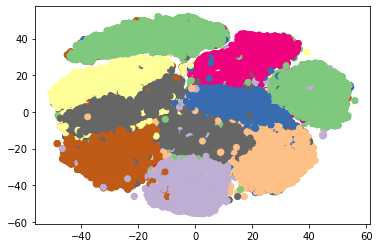

In [49]:
#visualization
y_MNIST_adj = [int(x) for x in y_MNIST]
plt.scatter(x=X_TSNE[:,0], y=X_TSNE[:,1], c=y_MNIST_adj, cmap='Accent')
plt.show()

In [50]:
#  tSNE-преобразованные данные с 2 признаками
model_KMeans = KMeans(n_clusters=10, n_init=1000, random_state=42).fit_predict(X_TSNE)
vm_KMeans = v_measure_score(y_MNIST, model_KMeans)
s_KMeans = silhouette_score(X_MNIST, model_KMeans)

print(f'K-means кластеризация: силуэт - {s_KMeans}, V-мера - {vm_KMeans}.')

K-means кластеризация: силуэт - 0.026640063807404187, V-мера - 0.7356942208612278.


In [51]:
# Model 2

In [55]:
X_TSNE = TSNE(n_components=2, random_state=42).fit_transform(X_MNIST)

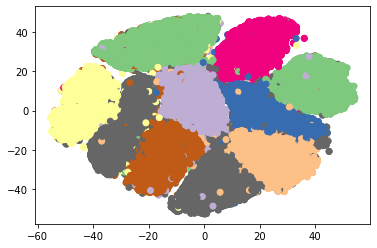

In [56]:
#visualization
y_MNIST_adj = [int(x) for x in y_MNIST]
plt.scatter(x=X_TSNE[:,0], y=X_TSNE[:,1], c=y_MNIST_adj, cmap='Accent')
plt.show()

In [57]:
#  tSNE-преобразованные данные с 2 признаками
model_KMeans = KMeans(n_clusters=10, n_init=1000, random_state=42).fit_predict(X_TSNE)
vm_KMeans = v_measure_score(y_MNIST, model_KMeans)
s_KMeans = silhouette_score(X_MNIST, model_KMeans)

print(f'K-means кластеризация: силуэт - {s_KMeans}, V-мера - {vm_KMeans}.')

K-means кластеризация: силуэт - 0.032817868336136057, V-мера - 0.7477730890697055.
